In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Tutorial B6: Design

> ersatz (substitute) + predict + ersatz (substitute) + predict + ...

Most of the functions we've discussed so far center around extracting what a sequence-based machine learning model has learned after training. Marginalization experiments show the individual effect that each motif has on model predictions; ISM shows the individual effect that each mutation has on model predictions within an observed sequence. However, these models can be used for more than just identifying relevent sequence features and their syntax rules.

For example, trained sequence-based models can be used in the design setting. Although these are numerous methods for designing sequences, each with their own set of important details, the overall approach is to train a model that predicts some sort of readout of interest and then perturb the sequence input until the predicted output matches what is desired by the user. Sometimes, this involves starting with an informative sequence and designing edits, other times this involves the <i>de novo</i> generation of sequences from scratch that exhibit the desired characters. Regardless, the trained model is considered to be an "oracle" that outputs how good the in-progress sequence is.

#### Greedy Substitution

The most conceptually simple design method is that of greedy substitution. Given an initial sequence, a predictive model, an output goal, and a set of motifs that one could substitute into the sequence, the task is to find which motifs and what exact positioning should be used to achieved a desired output from the predictive model. Because the aim here is to be conceptually simple, the method proceeds across several iterations where at each iteration, every motif is tried at every position in the sequence, and the motif+position pair that yields the largest improvement in terms of getting the model towards its goal. Naturally, this can be very time consuming but is the most straightforward approach.

Let's start by loading up the Beluga model again.

In [2]:
import torch
from model import Beluga

model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))

<All keys matched successfully>

Let's see if we can get this model to design a sequence that predicts high AP-1 binding. Yes, this task is unrealistically simple because AP-1 factors bind to a known motif and one could just insert that into the sequence, but it's a good initial task to show how to use the function.  

For the purpose of this example, we can randomly generate a single sequence and use a subset of predefined motifs from JASPAR. Here, we have inserted a motif that we known the Beluga AP-1 tasks respond to as the third motif in the list. 

In [3]:
import numpy
from tangermeme.utils import random_one_hot

X = random_one_hot((1, 4, 2000), random_state=0).type(torch.float32)
motifs = [
    'GCTAATTAAC',
    'ATGCCCACC',
    "GTGACTCATC",
    'AGAACAGAATGTTCT',
    'TGATGACGTCATCGC',
    'ACATTCCA',
    'GGGAGGAGGGAGAGGAGGAG',
    'TAATCGATTA',
    'CGTCTAGACA',
    'TGCTATTTTTAG',
    'CATTGTTTATTT',
    'TTTCACACCTAGGTGTGAAA',
    'GGCACGCGCC'
]

Next, we need a target that we are trying to get the model to predict with the designed sequence. In this case, we probably want all of the tasks for AP-1 factor proteins (e.g., c-/FOS, c-/JUN, etc). Since the predictions from Beluga are in logit space, we can set it to a relatively high positive value to indicate that we want binding of those specific tasks. Note that the first dimension is `1`. Although this method will accept a batch of sequences, the batch size must be `1` because, here, you are designing a single sequence.

In [4]:
names = numpy.loadtxt("beluga_target_names.txt", delimiter=',', dtype=str)
idxs = torch.tensor(['jun' in n.lower() or 'fos' in n.lower() for n in names])

y = torch.zeros(1, 2002)
y[:, idxs] = 3

Now, we can call the function. This function has a similar signature to other `tangermeme` functions in that it takes in the predictive model, the initial sequence, and a list of motifs. It differs from other functions in that it also takes in `y`, which is the target that we want the predictive model to output. Optionally, `greedy_substitution` can take in a mask that is applied to the predictions from the model and the target. Basically, if your model makes predictions for more outputs than you care about, this mask lets you remove some of those outputs from the loss. In our case, we can remove all predictions not related to the AP-1 factors and say that we want to design a sequence with the highest binding of AP-1 factors regardless of what happens to all other tasks.

In [5]:
from tangermeme.design import greedy_substitution

X_hat = greedy_substitution(model, X, motifs, y, output_mask=idxs, max_iter=5, verbose=True)

Iteration 0 -- Loss: 72.96, Improvement: N/A, Idx: N/A, Time (s): 0s


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  3.05it/s]


Iteration 1 -- Loss: 14.17, Improvement: 58.79, Motif Idx: 17, Pos Idx: 966, Time (s): 8.531


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  3.05it/s]


Iteration 2 -- Loss: 7.049, Improvement: 7.118, Motif Idx: 15, Pos Idx: 1031, Time (s): 8.525


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  3.02it/s]


Iteration 3 -- Loss: 4.952, Improvement: 2.097, Motif Idx: 2, Pos Idx: 1068, Time (s): 8.622


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  3.03it/s]


Iteration 4 -- Loss: 4.222, Improvement: 0.7304, Motif Idx: 10, Pos Idx: 984, Time (s): 8.584


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  2.97it/s]

Iteration 5 -- Loss: 3.897, Improvement: 0.325, Motif Idx: 19, Pos Idx: 844, Time (s): 8.75


We can see what is happening during the process from the logs. `Iteration 0` is meant to show what the loss looks like before any substitutions are made. We specified that only three rounds should happen, but can also specify that the improvement must be above a certain threshold (`tol`, default is `1e-3`). The process will terminate early if adding in more motifs would cause a higher loss than the previous iteration. 

Unsurprisingly, by looking at the motif idx we can see that the AP-1 motif we know Beluga responds to has been chosen each time and that these insertions are somewhat close to each other. The middle is the sequence is not necessarily preferentially chosen by the design method, but it is possible that the models being used will prefer motifs to be in the middle of the sequence as an artifact of how they are trained. 

We can now take a look at what the predictions from the model look like before and after substituting in these motifs.

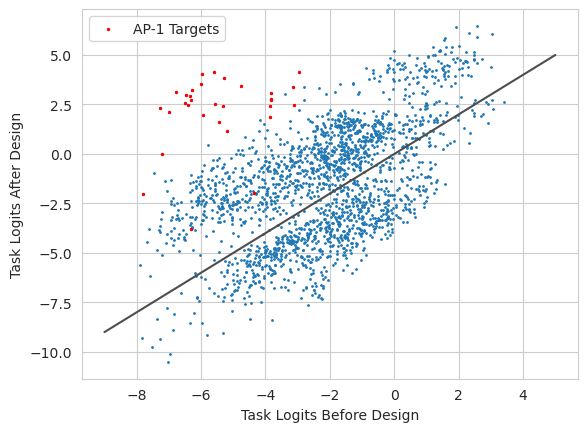

In [6]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

from tangermeme.predict import predict

y0 = predict(model, X).numpy(force=True)[0]
y1 = predict(model, X_hat).numpy(force=True)[0]

plt.plot([-9, 5], [-9, 5], c='0.3')
plt.scatter(y0, y1, s=1)
plt.scatter(y0[idxs], y1[idxs], s=2, color='r', label='AP-1 Targets')
plt.legend()
plt.xlabel("Task Logits Before Design")
plt.ylabel("Task Logits After Design")
plt.show()

Not only do we see that the tasks related to AP-1 binding have increased logits, we can see that they seem to be close to the desired value of 3. Interestingly, not all of the AP-1 tasks are increased to that level, and there seems to be quite a bit of a jitter in all of the other tasks. 

### Greedy Saturation Mutagenesis / Evolutionary Algorithms

Rather than implanting entire motifs into sequences, some approaches consider changing only one nucleotide at a time. This is sometimes done probabilistically, where only a subset of potential mutations are considered, and is sometimes comprehensive, e.g., saturation mutagenesis. Regardless, each approach proceeds similarly to the greedy approach described above: a nucleotide is changed, the change in score is recorded, and the best individual mutation is made at the end of each round.

This approach of only changing a single nucleotide in each round can be performed by simply passing in the four nucleotides as options rather than entire motifs.

In [7]:
X_hat = greedy_substitution(model, X, ['A', 'C', 'G', 'T'], y, reverse_complement=False, output_mask=idxs, max_iter=15, verbose=True)

Iteration 0 -- Loss: 72.96, Improvement: N/A, Idx: N/A, Time (s): 0s


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.92it/s]


Iteration 1 -- Loss: 53.44, Improvement: 19.51, Motif Idx: 2, Pos Idx: 1058, Time (s): 1.374


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Iteration 2 -- Loss: 40.33, Improvement: 13.12, Motif Idx: 2, Pos Idx: 1083, Time (s): 1.337


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Iteration 3 -- Loss: 32.48, Improvement: 7.841, Motif Idx: 3, Pos Idx: 1087, Time (s): 1.337


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.00it/s]


Iteration 4 -- Loss: 27.85, Improvement: 4.636, Motif Idx: 3, Pos Idx: 1029, Time (s): 1.335


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Iteration 5 -- Loss: 19.53, Improvement: 8.316, Motif Idx: 0, Pos Idx: 1031, Time (s): 1.317


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.99it/s]


Iteration 6 -- Loss: 13.43, Improvement: 6.098, Motif Idx: 1, Pos Idx: 1028, Time (s): 1.34


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


Iteration 7 -- Loss: 11.12, Improvement: 2.314, Motif Idx: 1, Pos Idx: 1035, Time (s): 1.324


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.86it/s]


Iteration 8 -- Loss: 9.499, Improvement: 1.621, Motif Idx: 3, Pos Idx: 994, Time (s): 1.401


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Iteration 9 -- Loss: 8.413, Improvement: 1.086, Motif Idx: 0, Pos Idx: 1061, Time (s): 1.319


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.02it/s]


Iteration 10 -- Loss: 7.222, Improvement: 1.191, Motif Idx: 3, Pos Idx: 1062, Time (s): 1.329


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Iteration 11 -- Loss: 6.564, Improvement: 0.6573, Motif Idx: 3, Pos Idx: 1086, Time (s): 1.322


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Iteration 12 -- Loss: 6.021, Improvement: 0.5431, Motif Idx: 3, Pos Idx: 1071, Time (s): 1.314


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.97it/s]


Iteration 13 -- Loss: 5.359, Improvement: 0.6618, Motif Idx: 1, Pos Idx: 1070, Time (s): 1.353


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]


Iteration 14 -- Loss: 4.796, Improvement: 0.5637, Motif Idx: 2, Pos Idx: 1065, Time (s): 1.322


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.04it/s]

Iteration 15 -- Loss: 4.527, Improvement: 0.2686, Motif Idx: 1, Pos Idx: 979, Time (s): 1.319


Each round is much faster because, although you are considering changes at roughly the same number of positions, you are considering a significantly smaller number of "motifs". However, you will likely need many more iterations because adding in a motif of length 8 will require 8 rounds rather than the single round in the other approach. Something interesting to note is that midway the improvement increases, indicating that an epistatic effect was discovered, i.e., that the inclusion of one or more earlier positions was required before that position could really improve output.

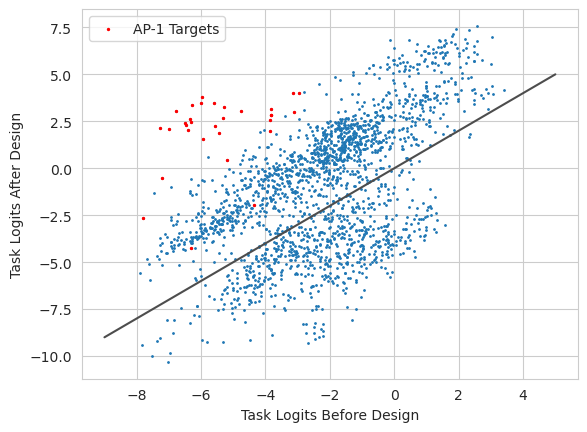

In [8]:
y0 = predict(model, X).numpy(force=True)[0]
y1 = predict(model, X_hat).numpy(force=True)[0]

plt.plot([-9, 5], [-9, 5], c='0.3')
plt.scatter(y0, y1, s=1)
plt.scatter(y0[idxs], y1[idxs], s=2, color='r', label='AP-1 Targets')
plt.legend()
plt.xlabel("Task Logits Before Design")
plt.ylabel("Task Logits After Design")
plt.show()

Looks like we are starting to get there, but are not as close as implanting ten entire motifs.

This method has strengths and weaknesses. The weaknesses are that it may take many more iterations to get good results and that it gives potentially too much flexiblility of the model, allowing it to overfit to spurious correlations (e.g., finding a random mutation that is not part of the model but happens to make the model predict closer to the desired output). The strengths are that it does not rely on a set of pre-identified set of motifs and so can make changes that fall outside the set of motifs, e.g., adding in a lower affinity version of a motif or an alternate version of the motif that is actually stronger than the one provided. 

#### Balancing Losses

Is it possible to design a sequence that keeps the other tasks as close to their original values as possible while still increasing the predictions for AP-1 binding? To do this, rather than using a mask to ignore the outputs from non-AP-1 tasks, we will set the target values for that task to the original predictions from the model.

In [9]:
y = predict(model, X)
y[:, idxs] = 3

X_hat2 = greedy_substitution(model, X, motifs, y, max_iter=10, verbose=True)

Iteration 0 -- Loss: 1.13, Improvement: N/A, Idx: N/A, Time (s): 0s


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  2.95it/s]


Iteration 1 -- Loss: 0.6533, Improvement: 0.4764, Motif Idx: 15, Pos Idx: 896, Time (s): 8.819


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  2.89it/s]


Iteration 2 -- Loss: 0.5997, Improvement: 0.05358, Motif Idx: 2, Pos Idx: 905, Time (s): 9.001


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  2.99it/s]


Iteration 3 -- Loss: 0.5819, Improvement: 0.01777, Motif Idx: 14, Pos Idx: 1063, Time (s): 8.694


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  2.96it/s]


Iteration 4 -- Loss: 0.5713, Improvement: 0.01067, Motif Idx: 13, Pos Idx: 852, Time (s): 8.774


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  2.99it/s]


Iteration 5 -- Loss: 0.5646, Improvement: 0.006629, Motif Idx: 12, Pos Idx: 704, Time (s): 8.688


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  2.92it/s]


Iteration 6 -- Loss: 0.5586, Improvement: 0.006042, Motif Idx: 23, Pos Idx: 1550, Time (s): 8.893


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:09<00:00,  2.89it/s]


Iteration 7 -- Loss: 0.5533, Improvement: 0.005298, Motif Idx: 3, Pos Idx: 805, Time (s): 9.019


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  2.97it/s]


Iteration 8 -- Loss: 0.5494, Improvement: 0.003871, Motif Idx: 12, Pos Idx: 1193, Time (s): 8.761


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  2.96it/s]


Iteration 9 -- Loss: 0.5464, Improvement: 0.003075, Motif Idx: 5, Pos Idx: 1588, Time (s): 8.781


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  2.97it/s]

Iteration 10 -- Loss: 0.5447, Improvement: 0.001643, Motif Idx: 11, Pos Idx: 1803, Time (s): 8.754


Unsurprisingly, we can see that the magnitude of the loss goes down because we are now averaging over two orders of magnitude more tasks. Interestingly, the model choose to include motif index 4 rather than motif index 2 in two of the iterations. This motif is the one for FOS-JUN on JASPAR but is considered to be a weaker AP-1 site by the Beluga model than the one we've been using thus far. Additionally, it looks like the motifs are placed in the sequence further apart than they were in the other example.

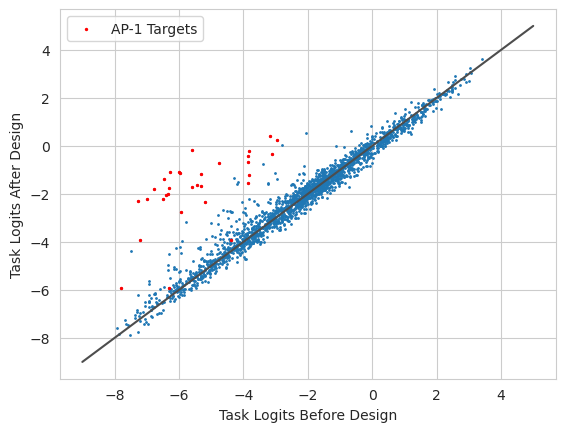

In [10]:
y0 = predict(model, X).numpy(force=True)[0]
y1 = predict(model, X_hat2).numpy(force=True)[0]

plt.plot([-9, 5], [-9, 5], c='0.3')
plt.scatter(y0, y1, s=1)
plt.scatter(y0[idxs], y1[idxs], s=2, color='r', label='AP-1 Targets')
plt.legend()
plt.xlabel("Task Logits Before Design")
plt.ylabel("Task Logits After Design")
plt.show()

And it seems like we've reached a new compromise! The AP-1 related tasks are nicely separated from the other tasks (except for two of them) and, although they do not reach the desired objective value of `3`, the flip side is that the other tasks seem to be much closer to their original values.


#### Input Masks

Sometimes, we may not want to consider substitutions at every position in the sequence. Perhaps we know that the most important part of the sequence is in the middle, or have known motifs in our sequence that we want to protect, or maybe we just do not need to be as precise as considering any possible possible. Regardless of the reason for having a mask, using one can speed up design significantly.

Normally, the input to the model is 2000 bp. What happens if we only use the middle 200 bp for design?

In [11]:
y = predict(model, X)
y[:, idxs] = 3

input_mask = torch.zeros(2000, dtype=bool)
input_mask[900:1100] = True

X_hat2 = greedy_substitution(model, X, motifs, y, max_iter=5, input_mask=input_mask, verbose=True)

Iteration 0 -- Loss: 1.13, Improvement: N/A, Idx: N/A, Time (s): 0s


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 28.06it/s]


Iteration 1 -- Loss: 0.657, Improvement: 0.4727, Motif Idx: 2, Pos Idx: 904, Time (s): 0.929


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 29.36it/s]


Iteration 2 -- Loss: 0.6221, Improvement: 0.03495, Motif Idx: 15, Pos Idx: 1099, Time (s): 0.8877


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 28.05it/s]


Iteration 3 -- Loss: 0.5962, Improvement: 0.02583, Motif Idx: 1, Pos Idx: 999, Time (s): 0.93


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 29.01it/s]


Iteration 4 -- Loss: 0.5871, Improvement: 0.00909, Motif Idx: 5, Pos Idx: 922, Time (s): 0.9012


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 28.55it/s]

Iteration 5 -- Loss: 0.582, Improvement: 0.005167, Motif Idx: 8, Pos Idx: 945, Time (s): 0.9153


As you might expect, we see a pretty big speed improvement -- around a 10x improvement in speed when only considering one tenth of the positions. That makes sense. But how do the results look?

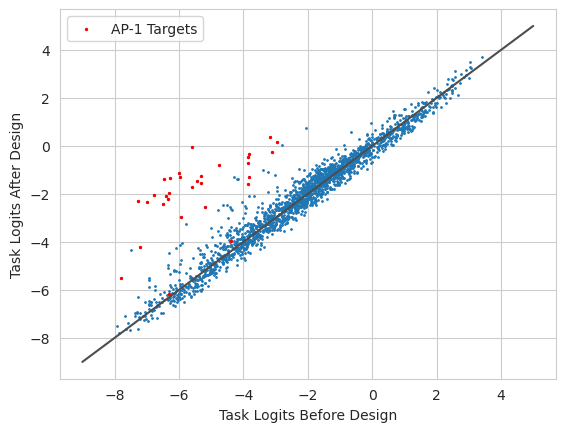

In [12]:
y0 = predict(model, X).numpy(force=True)[0]
y1 = predict(model, X_hat2).numpy(force=True)[0]

plt.plot([-9, 5], [-9, 5], c='0.3')
plt.scatter(y0, y1, s=1)
plt.scatter(y0[idxs], y1[idxs], s=2, color='r', label='AP-1 Targets')
plt.legend()
plt.xlabel("Task Logits Before Design")
plt.ylabel("Task Logits After Design")
plt.show()

The results look quite similar to before. However, this is likely because the original sequence we used was completely randomly generated and the improvements are likely coming from simply adding AP-1 motifs nearby to each other, so limiting the possible space isn't a huge constraint. In settings with actual structured sequences as input or where running more iterations to get the maximum possible improvement is necessary, having more sequence can be helpful.

#### Loss Functions

By default, the loss used is `torch.nn.MSELoss` without reduction because it is a reasonable and general-purpose loss. However, you can use whatever loss you'd like by passing the loss function into `loss=...`. This can be any loss implemented in PyTorch that is reasonable for your model or any custom function with the signature `def loss(y, y_hat)` with `y.shape == (n, ...)` that returns a tensor with size `(n, ...)`. Basically, every example that gets passed into the loss function needs to have one or more losses associated with it. Everything except for the first dimension gets averaged such that you get one value per example. This is a critical detail because, by default, PyTorch losses will average over the batch dimension as well and only give you a single number regardless of the number of examples passed in. The design function needs to know the example with the minimal loss and so any function -- custom or not -- needs to return the loss for each example. 

To demonstrate, let's do the design but use a different loss function.

In [13]:
y = predict(model, X)
y[:, idxs] = 3

X_hat3 = greedy_substitution(model, X, motifs, y, max_iter=3, loss=torch.nn.HuberLoss(reduction='none'), verbose=True)

Iteration 0 -- Loss: 0.1229, Improvement: N/A, Idx: N/A, Time (s): 0s


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  2.97it/s]


Iteration 1 -- Loss: 0.1188, Improvement: 0.004089, Motif Idx: 5, Pos Idx: 910, Time (s): 8.753


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  2.97it/s]

Iteration 2 -- Loss: 0.1185, Improvement: 0.0003167, Motif Idx: 14, Pos Idx: 692, Time (s): 8.774


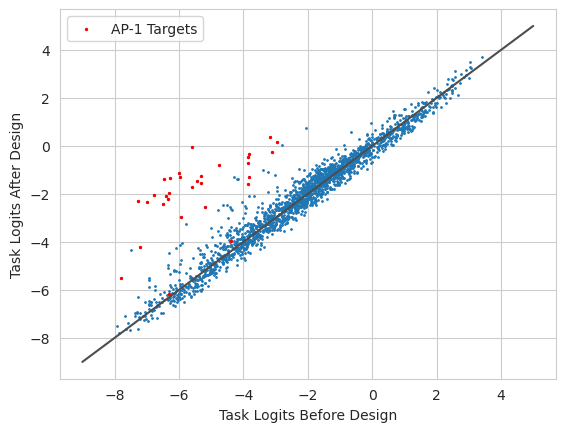

In [14]:
y0 = predict(model, X).numpy(force=True)[0]
y1 = predict(model, X_hat2).numpy(force=True)[0]

plt.plot([-9, 5], [-9, 5], c='0.3')
plt.scatter(y0, y1, s=1)
plt.scatter(y0[idxs], y1[idxs], s=2, color='r', label='AP-1 Targets')
plt.legend()
plt.xlabel("Task Logits Before Design")
plt.ylabel("Task Logits After Design")
plt.show()

#### Elimination of Motifs

An important part of this greedy procedure is that it does not only involve inserting new motifs into uninformative sequence, but that it will eliminate motifs that yield activity that the model does not want. As an illustration, let's consider the simple case where a motif drives unwanted AP-1 binding activity and the goal is to design a sequence that does not exhibit AP-1 binding.

Here, we will start with a sequence that has the AP-1 motif in it already.

In [15]:
from tangermeme.ersatz import substitute

X = random_one_hot((1, 4, 2000), random_state=0).type(torch.float32)
X = substitute(X, "GTGACTCATC")

Now, we will specify that we want baseline levels of AP-1 binding while preserving everything else.

In [16]:
y = predict(model, X)
y[:, idxs] = -5

X_hat3 = greedy_substitution(model, X, motifs, y, max_iter=1, verbose=True)

Iteration 0 -- Loss: 0.1575, Improvement: N/A, Idx: N/A, Time (s): 0s


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  2.99it/s]

Iteration 1 -- Loss: 0.1182, Improvement: 0.03931, Motif Idx: 25, Pos Idx: 986, Time (s): 8.692


It looks like the process figured out that it should substitute in a motif that the model does not respond to (motif index 7) right in the middle of the sequence, where our AP-1 motif is, to eliminate it. Keep in mind that the process did not need to be told to eliminate motifs, or what motifs are uninformative. By being a comprehensive process, it can figure out both of these things in a data-driven manner. Further, the process can interleave the adding and eliminating of motifs -- it is not a "one or the other" situation. If some motifs need to be eliminated, and others need to be added, this procedure can figure that out (subject to the limitations of it being a greedy algorithm).

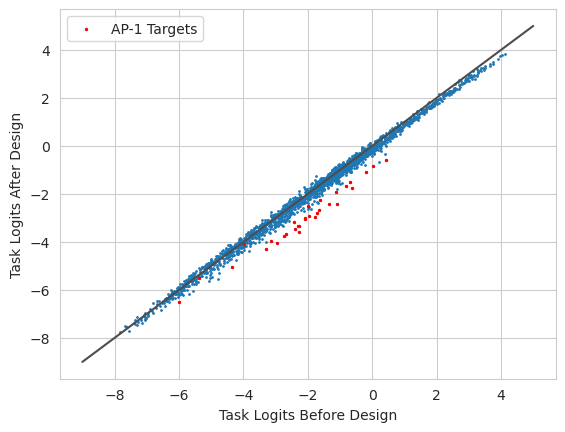

In [17]:
y0 = predict(model, X).numpy(force=True)[0]
y1 = predict(model, X_hat3).numpy(force=True)[0]

plt.plot([-9, 5], [-9, 5], c='0.3')
plt.scatter(y0, y1, s=1)
plt.scatter(y0[idxs], y1[idxs], s=2, color='r', label='AP-1 Targets')
plt.legend()
plt.xlabel("Task Logits Before Design")
plt.ylabel("Task Logits After Design")
plt.show()

And it looks like the predicted signal is lower after the elimination of the motif!

We can do a more targetted approach by using the greedy saturated mutagenesis approach.

Iteration 0 -- Loss: 0.1575, Improvement: N/A, Idx: N/A, Time (s): 0s


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.95it/s]

Iteration 1 -- Loss: 0.1187, Improvement: 0.03884, Motif Idx: 3, Pos Idx: 995, Time (s): 1.359


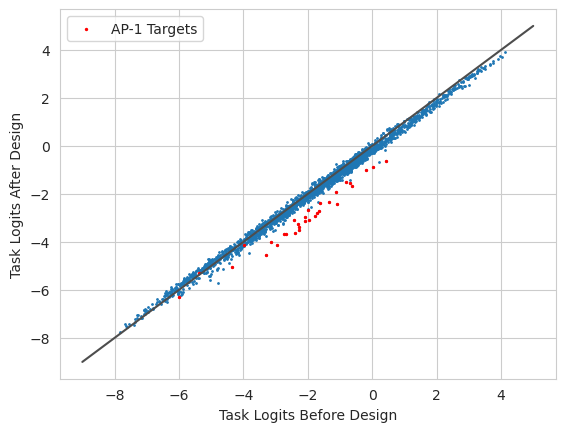

In [18]:
X_hat3 = greedy_substitution(model, X, ['A', 'C', 'G', 'T'], y, reverse_complement=False, max_iter=1, verbose=True)

y0 = predict(model, X).numpy(force=True)[0]
y1 = predict(model, X_hat3).numpy(force=True)[0]

plt.plot([-9, 5], [-9, 5], c='0.3')
plt.scatter(y0, y1, s=1)
plt.scatter(y0[idxs], y1[idxs], s=2, color='r', label='AP-1 Targets')
plt.legend()
plt.xlabel("Task Logits Before Design")
plt.ylabel("Task Logits After Design")
plt.show()

With only a single mutation knocking out a key position in the motif, we are able to achieve similar results. 

#### Half Precision

A strength of this prediction-based design is that it is fairly robust to operating at lower precision because we are simply looking for the best motif and position, rather than needing a very precise value, and if two choices happen to be similar and swapped at lower precision the consequences for design are minimal.

In [19]:
y = torch.zeros(1, 2002)
y[:, idxs] = 3

print("Full Precision")
X_hat = greedy_substitution(model.float(), X.float(), motifs, y.float(), output_mask=idxs, max_iter=3, verbose=True)

print("\nHalf Precision")
X_hat = greedy_substitution(model.half(), X.half(), motifs, y.half(), output_mask=idxs, max_iter=3, verbose=True)

Full Precision
Iteration 0 -- Loss: 28.47, Improvement: N/A, Idx: N/A, Time (s): 0s


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:09<00:00,  2.89it/s]


Iteration 1 -- Loss: 7.546, Improvement: 20.93, Motif Idx: 15, Pos Idx: 979, Time (s): 9.007


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  3.02it/s]


Iteration 2 -- Loss: 4.787, Improvement: 2.759, Motif Idx: 15, Pos Idx: 1014, Time (s): 8.602


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:08<00:00,  3.04it/s]
/users/jmschr/anaconda3/lib/python3.12/site-packages/torch/nn/functional.py:3366: UserWarning: Applying the CPU mse kernel on half-type tensors. This may be slower than using float or double-type tensors. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/cpu/BinaryOpsKernel.cpp:952.)
  return torch._C._nn.mse_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))


Iteration 3 -- Loss: 4.134, Improvement: 0.652, Motif Idx: 22, Pos Idx: 1040, Time (s): 8.564

Half Precision
Iteration 0 -- Loss: 28.47, Improvement: N/A, Idx: N/A, Time (s): 0s


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:05<00:00,  4.71it/s]


Iteration 1 -- Loss: 7.543, Improvement: 20.92, Motif Idx: 15, Pos Idx: 979, Time (s): 5.53


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:05<00:00,  4.85it/s]


Iteration 2 -- Loss: 4.789, Improvement: 2.754, Motif Idx: 15, Pos Idx: 1014, Time (s): 5.368


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:05<00:00,  4.84it/s]

Iteration 3 -- Loss: 4.133, Improvement: 0.6562, Motif Idx: 22, Pos Idx: 1040, Time (s): 5.373


Looks like we are getting the same motifs inserted at the same positions, but with a nice speed boost. Using half precision also potentially enables one to use a bigger batch size, which can be helpful for the modern GPUs that might be underutilized.

### Designing Constructs

An alternate view of design is that, rather than designing individual sequences, you want to design a construct with desired changes in model predictions *on average* when included in a sequence. Basically, rather than ending up with a single sequence where the design may have picked up on specific properties or other motifs already present, you want to design a small construct (of variable width) that can be included in other sequences to induce desired properties. This perspective is similar to the idea of de novo motif discovery, where one wants to find repeating patterns that *on average* are picked up on by the statistical or machine learning model.

This method works by using repeated marginalizations for design. First, each individual motif is implanted into the middle of a set of background sequences and the one that pushes model predictions in the right direction the most is kept. Then, each motif is considered at each position from a provided `max_spacing` to the left of the left-most part of the motif to that same distance to the right. To be clear, when a `max_spacing` of 4 is provided, there will be a maximum of 4 positions between the right-most of the newly inserted motif and the left-most of the previous left flank, and likewise at the end. Because all positions in this span are considered, motifs can be implanted on top of each other to attenuate their effect. At the end of this process, you will end up with a construct that, on average, pushes model predictions by the amount provided as `y`. This is in contrast to the `greedy_substitution` method which will end up with a sequence where the total model predictions are `y`. 

On average, this function is roughly the same speed as the `greedy_substitution` function because, while it does not consider all positions in the sequence, it performs an in silico marginalization at each step over the number of provided background sequences. 

We can do this with a very similar function call. Remember here that `X` is a set of background sequences, not a single sequence to optimize, and that `y` is how much including this construct pushes model predictions, not the actual predictions of the model. Put another way, `y` is `f(X + construct) - f(X)`, not `f(X + construct)`.

In [20]:
from tangermeme.design import greedy_marginalize

y = torch.zeros(1, 2002)
y[:, idxs] = 1

X = random_one_hot((20, 4, 2000), random_state=0).float()
X_hat4 = greedy_marginalize(model, X, motifs, y, output_mask=idxs, max_iter=20, verbose=True)
X_hat4.shape

Iteration 0 -- Loss:  1.0, Improvement: N/A, Idx: N/A, Time (s): 0s


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 70.07it/s]


Iteration 1 -- Loss: 0.8707, Improvement: 0.1293, Motif Idx: 23, Pos Idx: 999, Time (s): 0.3736


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:09<00:00,  2.61it/s]


Iteration 2 -- Loss: 0.4476, Improvement: 0.4231, Motif Idx: 25, Pos Idx: 983, Time (s): 9.956


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:12<00:00,  2.04it/s]


Iteration 3 -- Loss: 0.3146, Improvement: 0.1329, Motif Idx: 22, Pos Idx: 997, Time (s): 12.82


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:13<00:00,  1.93it/s]


Iteration 4 -- Loss: 0.2479, Improvement: 0.06674, Motif Idx: 25, Pos Idx: 1007, Time (s): 13.49


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:13<00:00,  1.89it/s]


Iteration 5 -- Loss: 0.1982, Improvement: 0.04969, Motif Idx: 8, Pos Idx: 1024, Time (s): 13.77


100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:17<00:00,  1.51it/s]


torch.Size([4, 51])

A one-hot encoding is returned from this function, so we can take a look at what was designed using the `characters` function which is the conceptual opposite of a one-hot encoding.

In [21]:
from tangermeme.utils import characters

characters(X_hat4, allow_N=True)

'GGCGCGTGCCNNNNCTAAAAATAGGGCGCGTGCCNNNNNNNCGTCTAGACA'

Interestingly, adding in a single AP-1 motif would increase predictions by significantly more than the desired value of 1. Instead, the method constructs weaker versions of the binding sites by overlapping motifs.

In [22]:
from tangermeme.marginalize import marginalize

y_before, y_after = marginalize(model, X, X_hat4.unsqueeze(0))
(y_after - y_before)[:, idxs].mean()

tensor(0.9614, dtype=torch.float16)

#### Final Words

Design can be a tricky process with many tradeoffs, particularly when it comes to genomics. One may need multiple iterations and trying out several strategies before converging on one that yields consistently good edits. This is, in part, because we have not yet fully converged on language for describing the pros and cons of various design methods. It is my hope that packages like `tangermeme`, and the design methods implemented here, can help move the field forward by standardizing some of the language we use to describe the design process.